# Final project report - Metadynamics

### Names: Netanel Bachar & David Stark
### IDs: ??? & 203865761

Perform Metadynamics simulations at $298K$ for a Ar atom in the double well potential energy surface:   
<center>$V(x)=Ax^4-Bx^2$</center>   
where $A=4.11\cdot10^{20}Jm^{-4}, B=8.22Jm^{-2}$



## Introduction - the problem of sampling the whole potential surface - transition is a rare event

We can clearly see that the barrier between the two wells is pretty big.
<img src="Final/WellPotential.png">   

If we use the previous MC approach, we will sample only one of the wells because landing on somewhat better potential is difficult because of the large barrier. Making a few consecutive steps towards the second well is statistically unlikely especially if we consider the acceptance probability for a step to (a much) higher potential.  
Increasing the translation step size could help but we can see it still takes many steps "to get lucky". Also, more often than not, we don't know how the potential energy surface looks like to "easily" pick a decent translation step size.
<img src="Final/PositionMC.png">   


For the MD approach, the particle is stuck in the well and oscillates according to the starting position/energy. In some cases, the particle might start with enough energy to overcome a barrier, but we can't always be sure especially if we don't know what the potential surface looks like.
<img src="Final/PositionEnergyMD.png">  

## Langevine approach

langevine no gauss - making sure the temp is right through simulation
might have a rare ivent due to langevine   

<img src="Final/Langevine.png">  

simulating with tempreature of 298K did not deliver enough energy to overcome, using 400K we demonstrate the rare transition event

<img src="Final/Langevine400K.png">  

## Using metadynamics to enhance sampling

adding gaussian every NG iterations leads to an "escape" thus sampling the second well.
eventually both wells are filled as can be seen from the continious movement from side to side.

<img src="Final/Metadynamics.png"> 

We can derive the free energy surface from the minus potential energy of the deposited gaussian array   
this is a single run / simulation

<img src="Final/FES.png"> 

the potential energy surface from 5 simulations using a different seed

 '''Finally, obtain the unbiased free-energy surface of the system, using one of the approached described in the review, and compare it with your expectation based on the potential above. Evaluate the error on you free energy surface estimate by running several independent trajectories and evaluating their standard deviation'''

## Tempered metadynamics

the tempered approach of metadynamics...

# Code for the parts

## Metadynamics

### Ordinary metadynamics

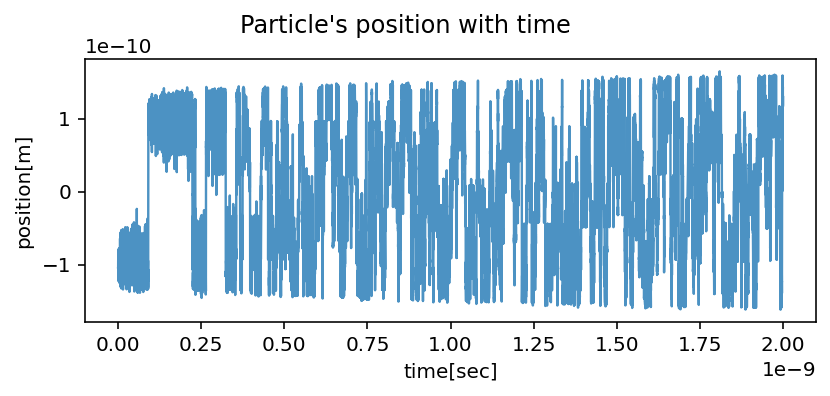

In [1]:
from sim import Simulation
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann as BOLTZMANN

fig = plt.figure(figsize=(6,3), dpi=144)
fig.suptitle("Particle's position with time", fontsize=12, y=0.90)
plt.xlabel('time[sec]', fontsize=10)
plt.ylabel('position[m]', fontsize=10)

R = np.array([[-1.05e-10, 0.0, 0.0]]) # In meters
mass = np.array([6.6335209e-26]) # Argon mass 
dt = 1.0e-15
sim = Simulation(dt=dt, L=5e-10, Nsteps=2000000, R=R, mass=mass, kind=["Ar"], ftype="DoubleWell", printfreq=1, 
                 NG=500, wtm=False)
sim.runMeta(**{ "A": 4.11e20 , "B": 8.22 })
FES = sim.VG
xgrid = sim.RG
sim.__del__()

positions = list()
with open('sim.xyz') as file:
    for line in file:
        if 'Step' in line:
            step = float(line.split()[1])
        if 'Ar' in line:
            positions.append([step*dt,float(line.split()[1])])
positions = np.array(positions)
x,y = positions.T
plt.plot(x,y, linewidth=1.2, linestyle='-', alpha=0.8)

plt.tight_layout()

# plt.savefig('Final/Metadynamics2M.png', bbox_inches='tight')

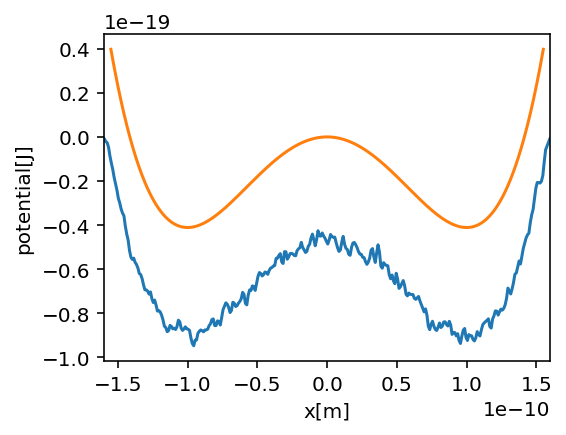

In [34]:
fig = plt.figure(figsize=(4,3), dpi=144)
plt.xlabel('x[m]')
plt.ylabel('potential[J]')
plt.xlim(-1.6e-10, 1.6e-10)

plt.plot(xgrid, -FES)

A = 4.11e20
B = 8.22
x = np.linspace(-1.55e-10, 1.55e-10, 1000)
V = A*x**4 - B*x**2
plt.plot(x, V)

# plt.savefig('Final/FES.png', bbox_inches='tight')

### Well tempered metadynamics

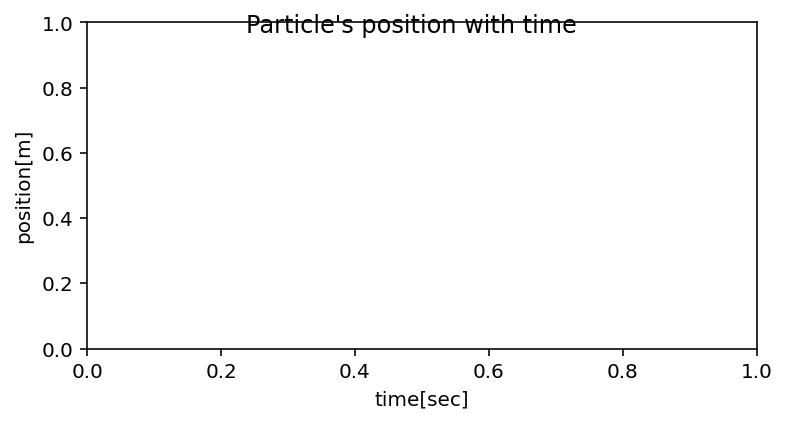

In [27]:
from sim import Simulation
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann as BOLTZMANN

fig = plt.figure(figsize=(6,3), dpi=144)
fig.suptitle("Particle's position with time", fontsize=12, y=0.90)
plt.xlabel('time[sec]', fontsize=10)
plt.ylabel('position[m]', fontsize=10)

R = np.array([[-1.05e-10, 0.0, 0.0]]) # In meters
mass = np.array([6.6335209e-26]) # Argon mass 
dt = 1.0e-15
sim = Simulation(dt=dt, L=5e-10, Nsteps=100000, R=R, mass=mass, kind=["Ar"], ftype="DoubleWell", printfreq=1, 
                 NG=500, wtm=True)
sim.runMeta(**{ "A": 4.11e20 , "B": 8.22 })
R_wtm = sim.R_wtm
VG_wtm = sim.VG_wtm
ct_wtm = sim.ct_wtm
beta = sim.beta
sim.__del__()

reweight = np.exp(beta * (VG_wtm - ct_wtm))
counts, bins = np.histogram(R_wtm, weights = reweight)

# positions = list()
# with open('sim.xyz') as file:
#     for line in file:
#         if 'Step' in line:
#             step = float(line.split()[1])
#         if 'Ar' in line:
#             positions.append([step*dt,float(line.split()[1])])
# positions = np.array(positions)
# x,y = positions.T
# plt.plot(x,y, linewidth=1.2, linestyle='-', alpha=0.8)

# plt.tight_layout()

# plt.savefig('Final/Metadynamics.png', bbox_inches='tight')

(array([1., 1., 0., 1., 0., 0., 2., 0., 1., 1.]),
 array([-2.45436697e-20, -2.17014192e-20, -1.88591687e-20, -1.60169182e-20,
        -1.31746677e-20, -1.03324173e-20, -7.49016679e-21, -4.64791632e-21,
        -1.80566584e-21,  1.03658464e-21,  3.87883512e-21]),
 <BarContainer object of 10 artists>)

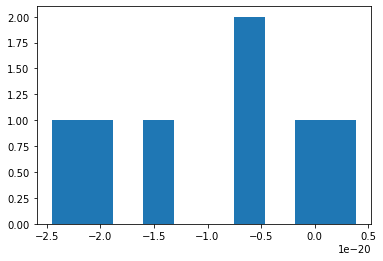

In [31]:
counts, bins = np.histogram(R_wtm, weights = reweight)
# plt.plot(bins[:-1], counts)

plt.hist(-1/beta * np.log(counts[counts!=0]))

## Introduction

### Well potential energy surface

Text(0, 0.5, 'potential [J]')

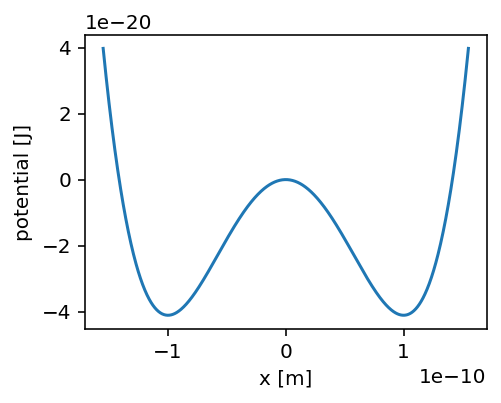

In [4]:
import matplotlib.pyplot as plt
import numpy as np

A = 4.11e20
B = 8.22
x = np.linspace(-1.55e-10, 1.55e-10, 1000)
V = A*x**4 - B*x**2

fig = plt.figure(figsize=(3.6,2.7), dpi=144)
plt.plot(x,V)
plt.xlabel('x [m]')
plt.ylabel('potential [J]')
# plt.savefig('Final/WellPotential.png', bbox_inches='tight')

### Particles position for two translation step sizes using MC

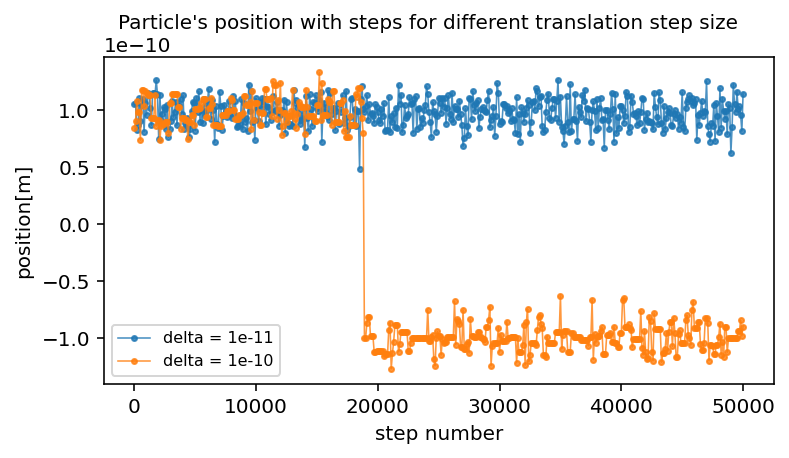

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sim import Simulation

R = np.array([[1.05e-10, 0.0, 0.0]])
mass = np.array([6.6335209e-26])
deltas = [1e-11, 1e-10]

sims_pos = list()

for delta in deltas:
    sim = Simulation(dt=1.0e-15, L=1.0, Nsteps=50000, R=R, mass=mass, deltaMC=delta,
                 kind=["Ar"], ftype="DoubleWell", printfreq=100,  outname="MCsim.log")
    sim.runMC(**{ "A": 4.11e20 , "B": 8.22 })
    sim.__del__()

    positions = list()
    with open('sim.xyz') as file:
        for line in file:
            if 'Step' in line:
                step = float(line.split()[1])
            if 'Ar' in line:
                positions.append([step,float(line.split()[1])])
            
    positions = np.array(positions)
    sims_pos.append(positions)

fig = plt.figure(figsize=(6,3), dpi=144)
fig.suptitle("Particle's position with steps for different translation step size", fontsize=10)
plt.xlabel('step number')
plt.ylabel('position[m]')

for positions in sims_pos:
    x,y = positions.T
    plt.plot(x,y, linewidth=0.8, linestyle='-', marker='o', markersize=2.5, alpha=0.8)
plt.legend(['delta = 1e-11', 'delta = 1e-10'], fontsize=8)

# plt.savefig('Final/PositionMC.png', bbox_inches='tight')

### Particles position and energy with time - NVE

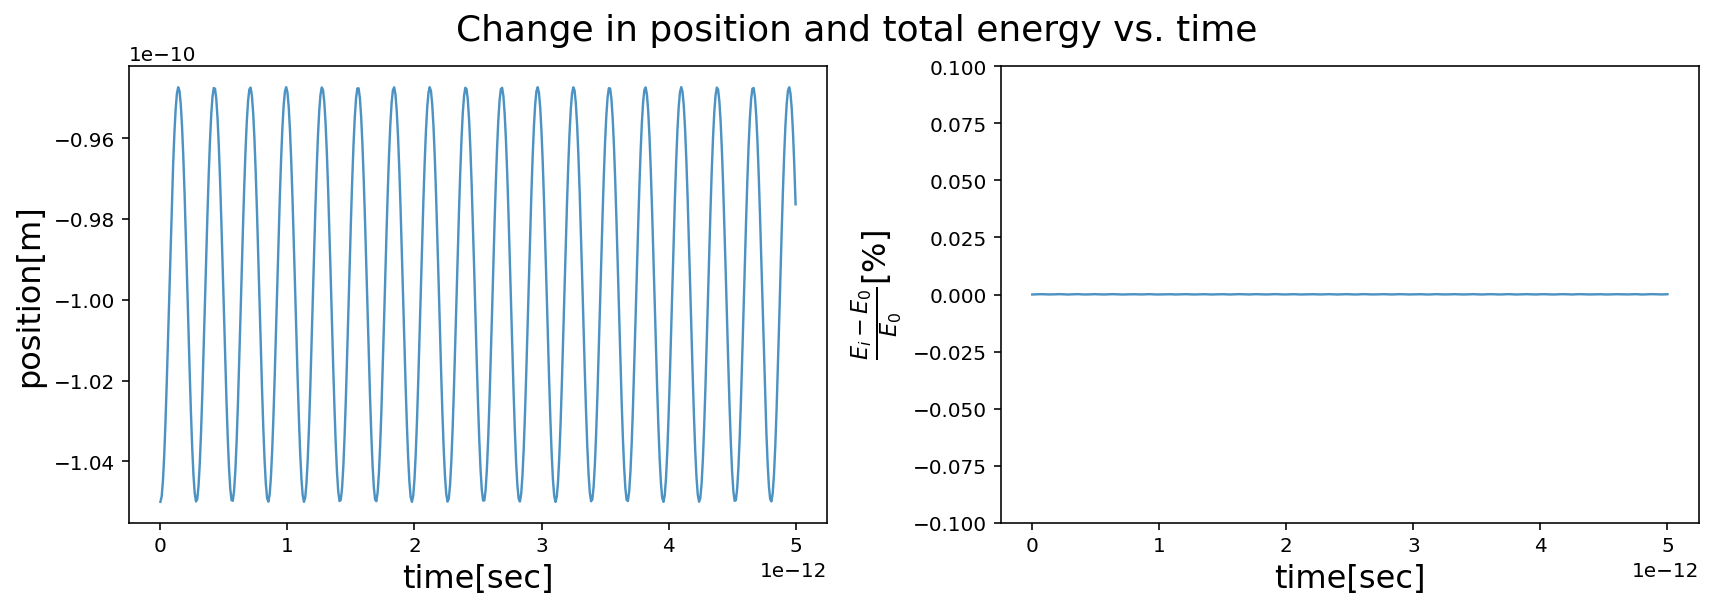

In [3]:
from sim import Simulation
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4.5), dpi=144)
plt.subplots_adjust(hspace=0.1)
ax1.set_xlabel('time[sec]', fontsize=16)
ax1.set_ylabel('position[m]', fontsize=16)
ax2.set_xlabel('time[sec]', fontsize=16)
ax2.set_ylabel(r'$\frac{E_i-E_0}{E_0}[\%]$', fontsize=16)
fig.suptitle('Change in position and total energy vs. time', fontsize=18, y=0.93)

R = np.array([[-1.05e-10, 0.0, 0.0]]) # In meters
mass = np.array([6.6335209e-26]) # Argon mass 
dt = 1.0e-15
sim = Simulation(dt=dt, L=5e-10, Nsteps=5000, R=R, mass=mass, kind=["Ar"], ftype="DoubleWell", printfreq=10)
sim.run(**{ "A": 4.11e20 , "B": 8.22 })
sim.__del__()

positions = list()
with open('sim.xyz') as file:
    for line in file:
        if 'Step' in line:
            step = float(line.split()[1])
        if 'Ar' in line:
            positions.append([step*dt,float(line.split()[1])])
positions = np.array(positions)
x,y = positions.T
ax1.plot(x,y, linewidth=1.2, linestyle='-', alpha=0.8)

energies = list()
with open('sim.log') as file:
    file.readline()
    for line in file:
        ener = line.split()
        kin, pot, tot = float(ener[1]), float(ener[2]), (float(ener[1])+float(ener[2]))
        energies.append([kin, pot, tot])
energies = np.array(energies).T

change_energy = (energies[2]-energies[2][0])*100/energies[2][0]
ax2.plot(x, change_energy, linewidth=1.2, linestyle='-', alpha=0.8)
ax2.set_ylim([-0.1,0.1])
plt.tight_layout()

# plt.savefig('Final/PositionEnergyMD.png', bbox_inches='tight')

### Validation of langevine dynamics through temperature

Mean temperature: 311.324724285575
 STD of particle position: 1.2812636893428473e-11


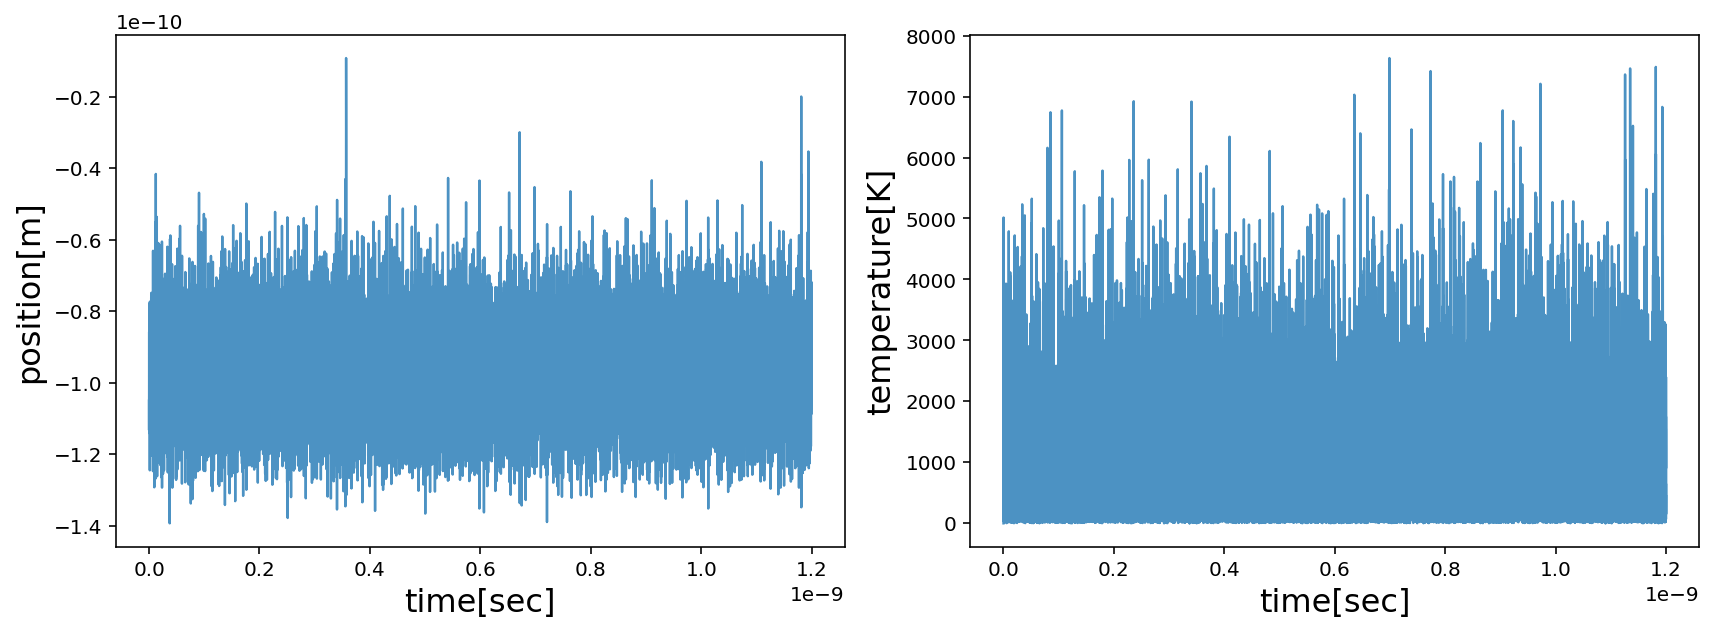

In [4]:
from sim import Simulation
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann as BOLTZMANN

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4.5), dpi=144)
plt.subplots_adjust(hspace=0.1)
ax1.set_xlabel('time[sec]', fontsize=16)
ax1.set_ylabel('position[m]', fontsize=16)
ax2.set_xlabel('time[sec]', fontsize=16)
ax2.set_ylabel('temperature[K]', fontsize=16)

R = np.array([[-1.05e-10, 0.0, 0.0]]) # In meters
mass = np.array([6.6335209e-26]) # Argon mass 
dt = 1.0e-15
sim = Simulation(dt=dt, L=5e-10, Nsteps=1200000, R=R, mass=mass, kind=["Ar"], ftype="DoubleWell", printfreq=10, 
                 NG=10_000_000)
sim.runMeta(**{ "A": 4.11e20 , "B": 8.22 })
sim.__del__()

positions = list()
with open('sim.xyz') as file:
    for line in file:
        if 'Step' in line:
            step = float(line.split()[1])
        if 'Ar' in line:
            positions.append([step*dt,float(line.split()[1])])
positions = np.array(positions)
x,y = positions.T
ax1.plot(x,y, linewidth=1.2, linestyle='-', alpha=0.8)

energies = list()
with open('sim.log') as file:
    file.readline()
    for line in file:
        ener = line.split()
        kin, pot, tot = float(ener[1]), float(ener[2]), (float(ener[1])+float(ener[2]))
        energies.append([kin, pot, tot])
energies = np.array(energies).T
temperature = 2 * energies[0] / BOLTZMANN
mean = np.mean(temperature[5:]) / 3 # since we used 3D
ax2.plot(x, temperature, linewidth=1.2, linestyle='-', alpha=0.8)
plt.tight_layout()
print(f"Mean temperature: {mean}\n STD of particle position: {np.std(y)}")

# plt.savefig('Final/Langevine.png', bbox_inches='tight')

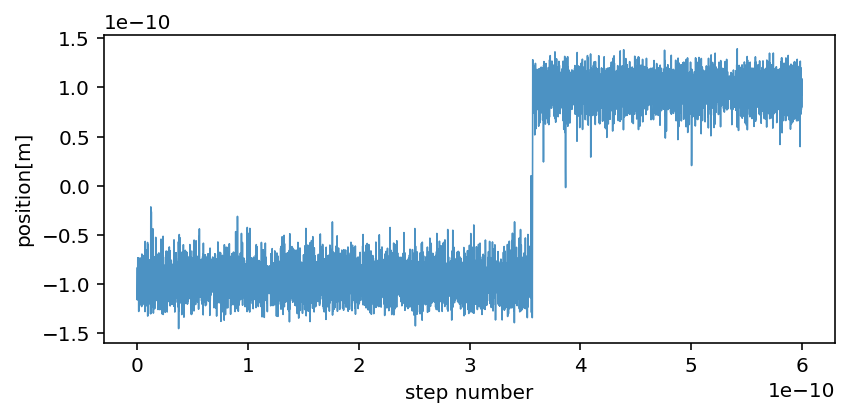

In [7]:
from sim import Simulation
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann as BOLTZMANN

R = np.array([[-1.05e-10, 0.0, 0.0]]) # In meters
mass = np.array([6.6335209e-26]) # Argon mass 
dt = 1.0e-15
sim = Simulation(dt=dt, L=5e-10, Nsteps=600000, R=R, mass=mass, kind=["Ar"], ftype="DoubleWell", printfreq=10, 
                 NG=10_000_000, temp=400)
sim.runMeta(**{ "A": 4.11e20 , "B": 8.22 })
sim.__del__()

positions = list()
with open('sim.xyz') as file:
    for line in file:
        if 'Step' in line:
            step = float(line.split()[1])
        if 'Ar' in line:
            positions.append([step*dt,float(line.split()[1])])
positions = np.array(positions)
x,y = positions.T

fig = plt.figure(figsize=(6,3), dpi=144)
plt.plot(x,y, linewidth=0.8, linestyle='-', alpha=0.8)
plt.xlabel('step number')
plt.ylabel('position[m]')

plt.tight_layout()

# plt.savefig('Final/Langevine400K.png', bbox_inches='tight')